In [1149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from functools import reduce
pd.set_option('future.no_silent_downcasting', True)

Load data frame

In [1150]:
columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'target']
df = pd.read_csv('./credit+approval/crx.data', names=columns, delimiter=',',  na_values='?')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c1      678 non-null    object 
 1   c2      678 non-null    float64
 2   c3      690 non-null    float64
 3   c4      684 non-null    object 
 4   c5      684 non-null    object 
 5   c6      681 non-null    object 
 6   c7      681 non-null    object 
 7   c8      690 non-null    float64
 8   c9      690 non-null    object 
 9   c10     690 non-null    object 
 10  c11     690 non-null    int64  
 11  c12     690 non-null    object 
 12  c13     690 non-null    object 
 13  c14     677 non-null    float64
 14  c15     690 non-null    int64  
 15  target  690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB


We can see that almost all columns have object type and we need to convert them to number type

Prepare data

In [1151]:
# Convert target "+" and "-" values to number 1 and 0 values
df['target'] = df['target'].map({"+": 1, "-": 0}).astype('int8')

# Collect columns which will encode to number values
encode_columns = ['c1', 'c4', 'c5', 'c6', 'c7', 'c9', 'c10', 'c12', 'c13']

# Creaate encoder
encoder = LeaveOneOutEncoder(cols=encode_columns)

# Transform data
df = encoder.fit_transform(df, df['target'])

# Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c1      690 non-null    float64
 1   c2      678 non-null    float64
 2   c3      690 non-null    float64
 3   c4      690 non-null    float64
 4   c5      690 non-null    float64
 5   c6      690 non-null    float64
 6   c7      690 non-null    float64
 7   c8      690 non-null    float64
 8   c9      690 non-null    float64
 9   c10     690 non-null    float64
 10  c11     690 non-null    int64  
 11  c12     690 non-null    float64
 12  c13     690 non-null    float64
 13  c14     677 non-null    float64
 14  c15     690 non-null    int64  
 15  target  690 non-null    int8   
dtypes: float64(13), int64(2), int8(1)
memory usage: 81.7 KB


In [1152]:
df.head(10)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,target
0,0.438972,30.83,0.000,0.492278,0.492278,0.507937,0.422111,1.250,0.786111,0.707483,1,0.428954,0.458333,202.0,0,1
1,0.464115,58.67,4.460,0.492278,0.492278,0.649351,0.627737,3.040,0.786111,0.707483,6,0.428954,0.458333,43.0,560,1
2,0.464115,24.50,0.500,0.492278,0.492278,0.649351,0.627737,1.500,0.786111,0.246193,0,0.428954,0.458333,280.0,824,1
3,0.438972,27.83,1.540,0.492278,0.492278,0.507937,0.422111,3.750,0.786111,0.707483,5,0.460317,0.458333,100.0,3,1
4,0.438972,20.17,5.625,0.492278,0.492278,0.507937,0.422111,1.710,0.786111,0.246193,0,0.428954,0.250000,120.0,0,1
5,0.438972,32.08,4.000,0.492278,0.492278,0.405405,0.422111,2.500,0.786111,0.246193,0,0.460317,0.458333,360.0,0,1
6,0.438972,33.17,1.040,0.492278,0.492278,0.500000,0.627737,6.500,0.786111,0.246193,0,0.460317,0.458333,164.0,31285,1
7,0.464115,22.92,11.585,0.492278,0.492278,0.700000,0.422111,0.040,0.786111,0.246193,0,0.428954,0.458333,80.0,1349,1
8,0.438972,54.42,0.500,0.271605,0.271605,0.260000,0.627737,3.960,0.786111,0.246193,0,0.428954,0.458333,180.0,314,1
9,0.438972,42.50,4.915,0.271605,0.271605,0.507937,0.422111,3.165,0.786111,0.246193,0,0.460317,0.458333,52.0,1442,1


We converted all categorial features to number values

Correlation info

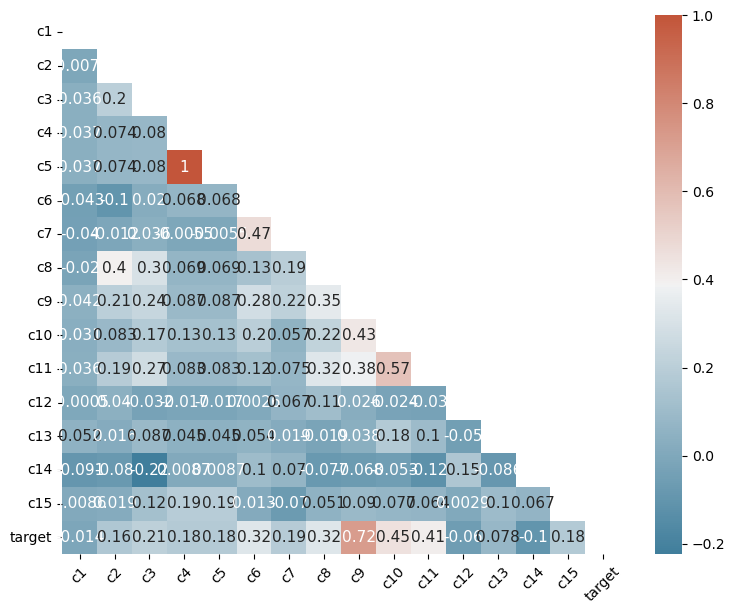

In [1153]:
# Build correlation matrix
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(9, 7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.xticks(rotation=45)
plt.show()

We can observe that 'C4' and 'C5' features have max correlation. We need drop one of them

In [1154]:
# Drop column 'c5'
df = df.drop('c5', axis=1)

#create a new features
c0_values = reduce(lambda x, y: y ** 2 / (x + y), [df[col] for col in df.columns])
c5_values = reduce(lambda x, y: np.sqrt(y * x) , [df[col] for col in df.columns])
df.insert(0, 'c0', c0_values)
df.insert(5, 'c5', c5_values)

df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,target
0,1.000000,0.438972,30.83,0.000,0.492278,0.000000,0.507937,0.422111,1.25,0.786111,0.707483,1,0.428954,0.458333,202.0,0,1
1,0.001918,0.464115,58.67,4.460,0.492278,7.411213,0.649351,0.627737,3.04,0.786111,0.707483,6,0.428954,0.458333,43.0,560,1
2,0.001623,0.464115,24.50,0.500,0.492278,0.000000,0.649351,0.627737,1.50,0.786111,0.246193,0,0.428954,0.458333,280.0,824,1
3,0.919342,0.438972,27.83,1.540,0.492278,2.226074,0.507937,0.422111,3.75,0.786111,0.707483,5,0.460317,0.458333,100.0,3,1
4,1.000000,0.438972,20.17,5.625,0.492278,0.000000,0.507937,0.422111,1.71,0.786111,0.246193,0,0.428954,0.250000,120.0,0,1


Make correllation again to ensure that everything is ok

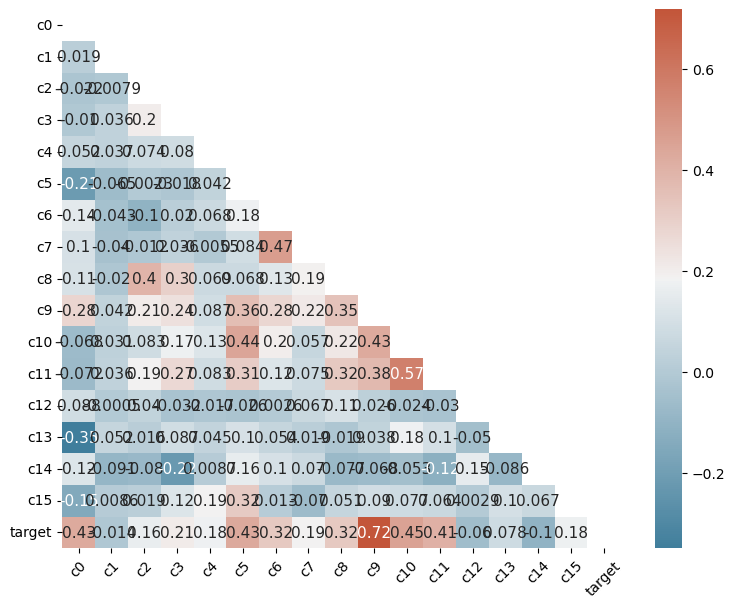

In [1155]:
# Build correlation matrix
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(9, 7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.xticks(rotation=45)
plt.show()

Now correlation matrix has good values. But previous one seems better

Visualize, visualize, visualize ...

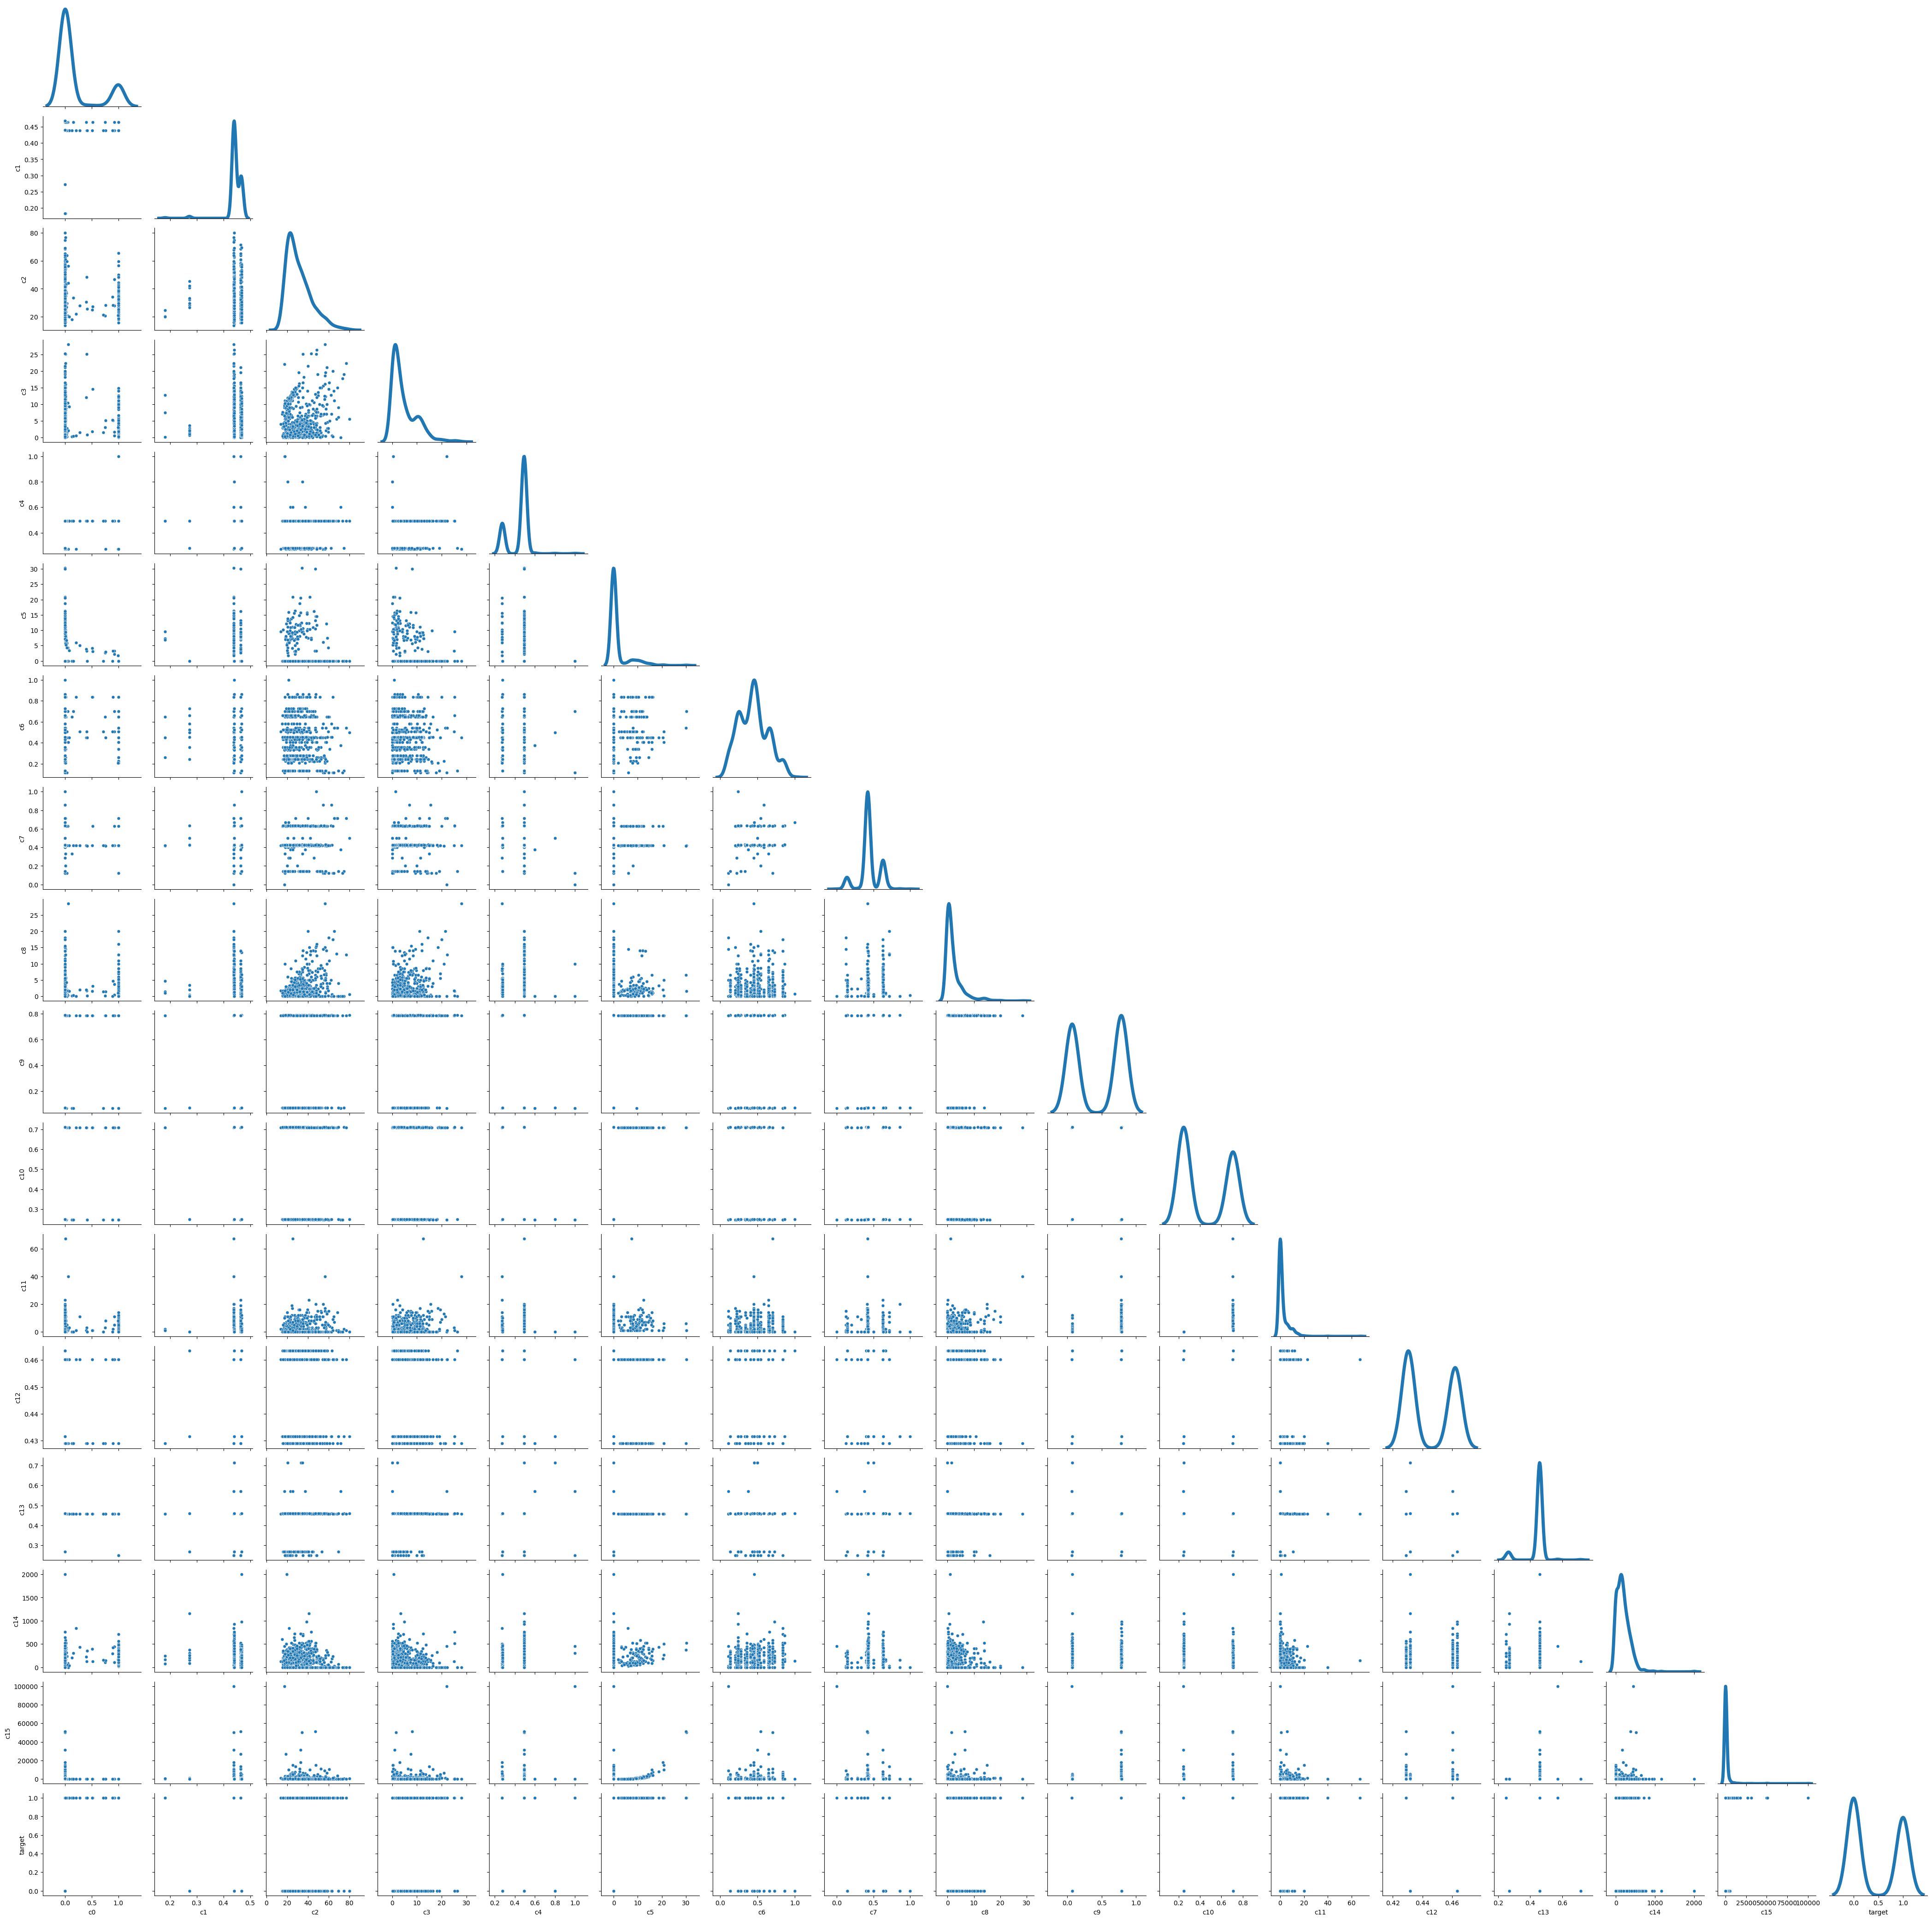

In [1156]:
# Visualize pair grid for our model
pairGrid = sns.PairGrid(df, corner=True, diag_sharey=False)

# Lower part of grid
pairGrid.map_lower(sns.scatterplot, s=25)

# Diagonal 
pairGrid.map_diag(sns.kdeplot, lw=5)

In the Grid above we can observe some minimal dependencies of feature and outlayers, but in general it won't be affected to result.

In [1157]:
# Split the data into features (X) and target variable (y)
X = df.drop("target", axis=1)
y = df["target"]

Scale and split the data

In [1158]:
# Scale the data using StandardScaler
scaler = MinMaxScaler()

# Scale X 
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Apply scaler to data frame and split out data in proportion 0.8 for train and 0.2 for test. 

In [1159]:
# Create Tree Classifier
tree_classifier = DecisionTreeClassifier(random_state=42)

In [1160]:
# Cross validation data
cross_val_score(tree_classifier, X_train, y_train, cv=4)

array([0.99275362, 0.98550725, 0.97826087, 1.        ])

In [1161]:
# Fit data
tree_classifier.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

We can observe that closs validatation has good balanced data

In [1162]:
# Create hyperparameters 
parameters = {"max_depth": np.arange(1, 11), "max_features": [0.5, 0.7, 1]}
grid_search = GridSearchCV(estimator = tree_classifier,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           verbose=0)


grid_search.fit(X_train, y_train)   
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)

print(classification_report(y_test, y_pred, target_names=[f'class_{i}' for i in range(2)]))

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        68
     class_1       1.00      1.00      1.00        70

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



Very well metrics. 

In [1163]:
# Get soer and best params
grid_search.best_score_, grid_search.best_params_

(np.float64(0.9981884057971014),
 {'max_depth': np.int64(7), 'max_features': 0.5})

In [1164]:
# Predict result
y_pred_imp = tree_classifier.predict(X_test)

# Calculate MSE error and R2 score
mse = mean_squared_error(y_test, y_pred_imp)
r2 = r2_score(y_test, y_pred_imp)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 0.028985507246376812
R-squared (R²): 0.8840336134453781


MSE equal 0.02 and R2 0.88 tell us that the model was trained excellent with 100% prediction.

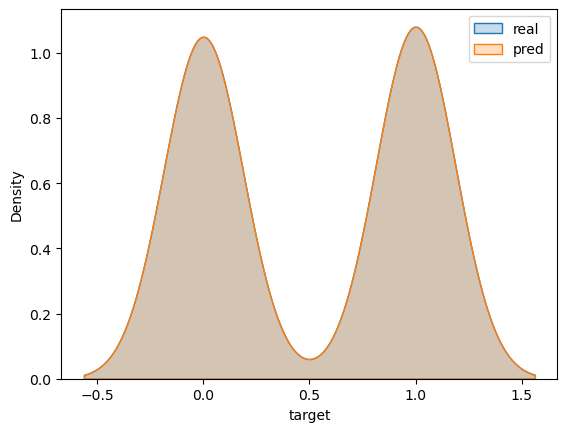

In [1165]:
# Visualize our result
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(y_pred, 0), fill=True, label='pred')
plt.legend()

The plot claims all our above conclusion. Very good result.